In this phase we will use filter methods, which are computionally less demending, but when used as a choice criterion, they are not connected with any considered model. 

We have to be very careful and dilligent to not leave any unnecessary variables (highly correlated), which will break our prediction, by bringing a lot of nosie without any additional predictive power. 

So we have two tasks:
- we will evaluate the correlation between each of this independent variables and target variable;
- we will evaluate the pairwise correlation between the independnent variables (multicolinearity);

In [64]:
# libraries for Data handling
import pandas as pd
import numpy as np
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
# libraries for statisical modelingL: for regression and ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
# libraries for categorical independence testing
from scipy.stats import chi2_contingency

In [65]:
# Load the cleaned, encoded training data, but before encoding categorical data
# we should remember that all the analysis have to be conducted only ioon training dataset.
companies_train = pd.read_pickle("outputs/df_companies_train.pkl")

# Display basic structure
print("Shape:", companies_train.shape)
print("Columns:", companies_train.columns.tolist())
print(companies_train.dtypes.value_counts())
companies_train.head()

Shape: (395, 38)
Columns: ['revenue', 'netincome', 'r&d', 'sg&a', 'ebit', 'revenuegrowth', 'ebitmargin', 'netmargin', 'rd_to_revenue', 'sga_to_revenue', 'operatingcashflow', 'capex', 'assets', 'equity', 'totaldebt', 'cash', 'liabilities', 'netdebt', 'investedcapital', 'freecashflow', 'capex_to_revenue', 'roa', 'roe', 'liabilities_to_equity', 'debt_to_equity', 'nopat', 'roic', 'sales_to_capital', 'fcf_to_netincome', 'revenuegrowth_t+1', 'label', 'GDPC1', 'CPIAUCSL', 'FEDFUNDS', 'UNRATE', 'GS10', 'UMCSENT', 'negative_equity_flag']
float64     36
category     1
bool         1
Name: count, dtype: int64


,revenue,netincome,r&d,sg&a,ebit,revenuegrowth,ebitmargin,netmargin,rd_to_revenue,sga_to_revenue,...,fcf_to_netincome,revenuegrowth_t+1,label,GDPC1,CPIAUCSL,FEDFUNDS,UNRATE,GS10,UMCSENT,negative_equity_flag
349,1.317845e+09,-345582000.0,2.943490e+08,7.425230e+08,-8.766200e+07,0.087642,-0.066519,-0.262233,0.223356,0.563437,...,0.037742,0.087090,AI‑DevOps,22249.459,292.625417,1.683333,3.641667,2.951667,58.975000,False
185,1.453047e+09,-243267000.0,2.715220e+08,9.913220e+08,-1.738550e+08,0.491879,-0.119649,-0.167419,0.186864,0.682237,...,-0.881990,0.450203,Enterprise SaaS,20771.691,258.855750,0.375833,8.100000,0.894167,81.541667,False
466,2.806489e+09,-836097000.0,1.287949e+09,1.714755e+09,-1.094773e+09,0.358641,-0.390086,-0.297916,0.458918,0.610997,...,-0.897215,0.292147,Cloud & Data,22960.600,304.704167,5.024167,3.633333,3.957500,65.350000,False
273,1.745500e+10,-496000000.0,2.054000e+09,7.105000e+09,-3.834000e+09,0.567017,-0.219651,-0.028416,0.117674,0.407047,...,1.497984,0.826239,Consumer SaaS,21960.388,270.967917,0.080000,5.358333,1.442500,77.616667,False
446,6.204450e+08,2702000.0,1.513640e+08,2.010540e+08,9.630000e+05,0.314828,0.001552,0.004355,0.243960,0.324048,...,18.964471,0.280052,Vertical SaaS,22960.600,304.704167,5.024167,3.633333,3.957500,65.350000,False


In [66]:
# Code for Correlation Matrix and Visual Inspection
# We're isolating the numeric features only (required for correlation analysis, regression, and feature selection);

companies_numeric_columns = companies_train.select_dtypes(include=[np.number]).columns

# Print the names of the columns for manual inspection.
print(companies_numeric_columns)

Index(['revenue', 'netincome', 'r&d', 'sg&a', 'ebit', 'revenuegrowth',
       'ebitmargin', 'netmargin', 'rd_to_revenue', 'sga_to_revenue',
       'operatingcashflow', 'capex', 'assets', 'equity', 'totaldebt', 'cash',
       'liabilities', 'netdebt', 'investedcapital', 'freecashflow',
       'capex_to_revenue', 'roa', 'roe', 'liabilities_to_equity',
       'debt_to_equity', 'nopat', 'roic', 'sales_to_capital',
       'fcf_to_netincome', 'revenuegrowth_t+1', 'GDPC1', 'CPIAUCSL',
       'FEDFUNDS', 'UNRATE', 'GS10', 'UMCSENT'],
      dtype='object')


In [67]:
# Code to generate a symmetric correlation matrix showing pairwise Pearson correlations between all numeric features.
# Useful first diagnostic for detecting:
# Multicollinearity (very high pairwise correlations, e.g. > 0.9);
# Redundant features that may not add independent value.
companies_corr_matrix = companies_train[companies_numeric_columns].corr(method = 'pearson')

# Show the matrix
print(companies_corr_matrix)

                        revenue  netincome       r&d      sg&a      ebit  \
revenue                1.000000   0.799540  0.934708  0.920399  0.821706   
netincome              0.799540   1.000000  0.684648  0.766584  0.996263   
r&d                    0.934708   0.684648  1.000000  0.949693  0.709710   
sg&a                   0.920399   0.766584  0.949693  1.000000  0.787778   
ebit                   0.821706   0.996263  0.709710  0.787778  1.000000   
revenuegrowth         -0.112613  -0.090827 -0.113651 -0.141563 -0.096273   
ebitmargin             0.232293   0.289420  0.229914  0.278963  0.290392   
netmargin              0.187132   0.241375  0.184705  0.223875  0.234198   
rd_to_revenue         -0.231229  -0.238164 -0.173263 -0.243216 -0.240971   
sga_to_revenue        -0.366665  -0.367897 -0.354214 -0.390982 -0.373761   
operatingcashflow      0.896017   0.971344  0.828146  0.880794  0.979156   
capex                  0.879879   0.681322  0.960377  0.924971  0.711512   
assets      

<Axes: >

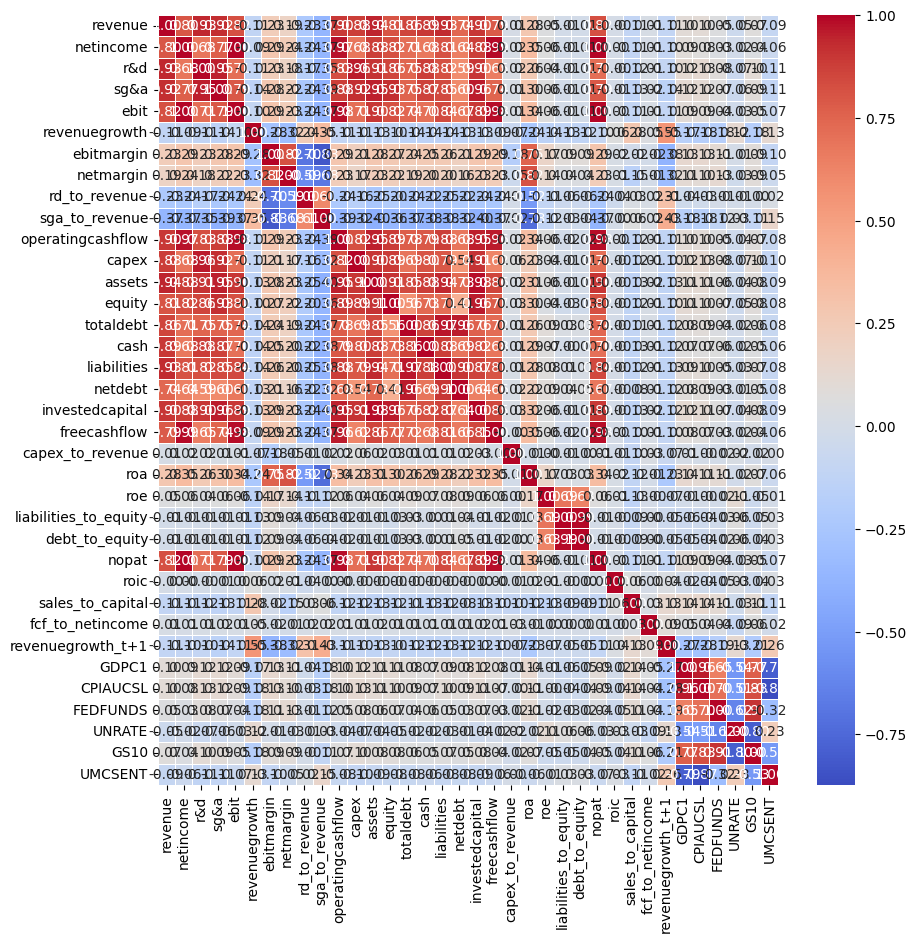

In [68]:
# A heatmap of the correlation matrix, which visually shows:
# Blue: negative correlation
# Red: positive correlation
# 1.0 on the diagonal: self-correlation(Pearson correlation is just a normalized covariance)
# Covariance measures how two variables move together — but its value depends on the units of the variables (e.g., PLN × %, or $ × kg)
# Pearson correlation rescales this to a unit-free measure between -1 and 1, so it's easier to interpret.
# Close to 1 or -1 off-diagonal → possible multicollinearity
# Visual inspection step before doing PCA, regression, or LASSO.

plt.figure(figsize=(10, 10))

sns.heatmap(companies_corr_matrix,
            annot = True,
            cmap = "coolwarm", 
            fmt = ".2f", 
            linewidths = 0.5)

In [69]:
# Generate a Mask for the Upper Triangle of the Matrix
# This creates a mask to hide the upper triangle of the symmetric correlation matrix in the heatmap.
# Since the matrix is symmetric, the lower and upper triangles mirror each other, and one half is enough to inspect.

# np.ones_like(...): creates a matrix of ones of the same shape as companies_corr_matrix.
# dtype=bool: instead of ones (1.0), this makes it a matrix of True values.
# np.triu(...): takes the upper triangle of that matrix and sets all other values to False.
mask = np.triu(np.ones_like(companies_corr_matrix, dtype=bool))

# Sort variables by absolute Pearson correlation with the target
target = 'revenuegrowth_t+1'
# abs() ensures you treat strong negative and positive correlations equally.
correlation_with_target = companies_corr_matrix[target].abs().sort_values(ascending=False)

# Reorder rows and columns of the Correlation Matrix Based on Relevance
ordered_columns = correlation_with_target.index

print(ordered_columns)


Index(['revenuegrowth_t+1', 'revenuegrowth', 'sga_to_revenue', 'ebitmargin',
       'netmargin', 'rd_to_revenue', 'CPIAUCSL', 'GDPC1', 'UMCSENT', 'roa',
       'GS10', 'FEDFUNDS', 'sg&a', 'sales_to_capital', 'UNRATE', 'liabilities',
       'assets', 'totaldebt', 'investedcapital', 'cash', 'netdebt',
       'operatingcashflow', 'revenue', 'nopat', 'ebit', 'freecashflow',
       'equity', 'r&d', 'netincome', 'capex', 'fcf_to_netincome',
       'capex_to_revenue', 'roe', 'liabilities_to_equity', 'debt_to_equity',
       'roic'],
      dtype='object')


<Axes: >

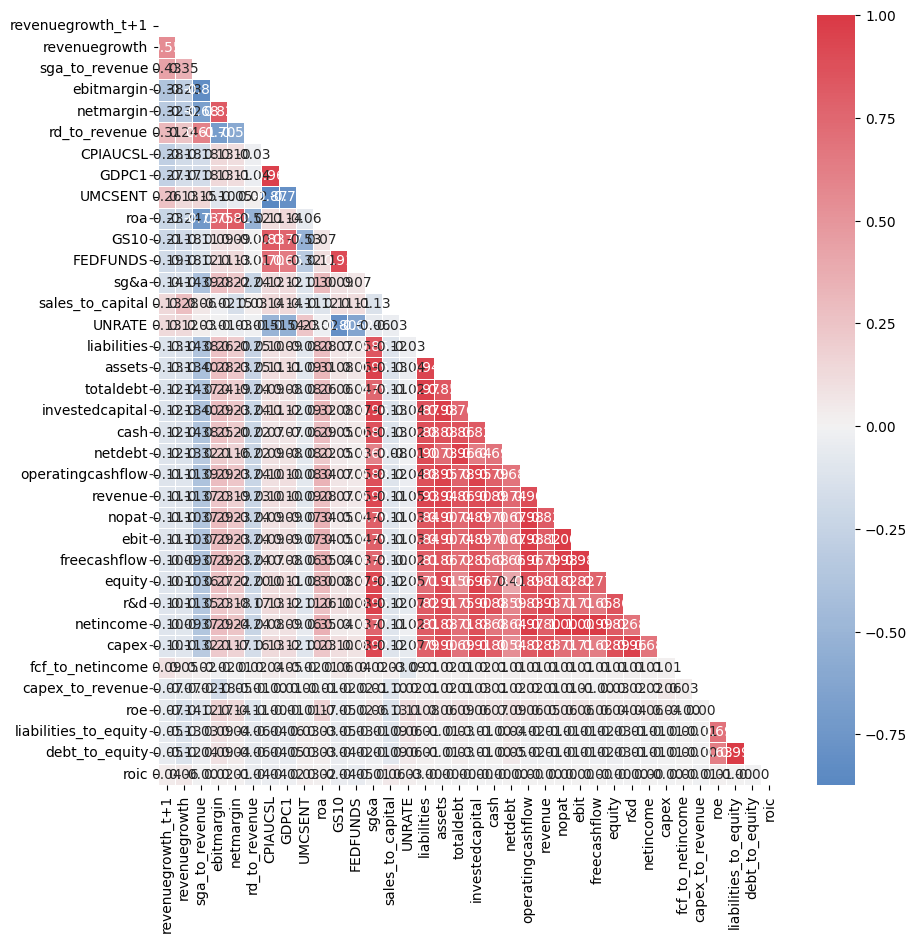

In [70]:
# Heatmap with Ordered Variables
# This helps visualize:
# Which top variables are mutually correlated: risk of multicollinearity;
# Which are uniquely related to the target: good candidates
# companies_corr_matrix[ordered_columns]: Reorders the columns of the matrix in this new order.
# .loc[ordered_columns]: Reorders the rows to match the new column order.
companies_corr_matrix = companies_corr_matrix[ordered_columns].loc[ordered_columns]

my_cmap = sns.diverging_palette(250, 10, as_cmap = True) 

plt.figure(figsize=(10, 10))

sns.heatmap(companies_corr_matrix,
            annot = True,
            cmap = my_cmap, 
            mask = mask,  # The mask hides the upper triangle for clarity.
            fmt = ".2f", 
            linewidths = 0.5,
            center = 0)

<Axes: >

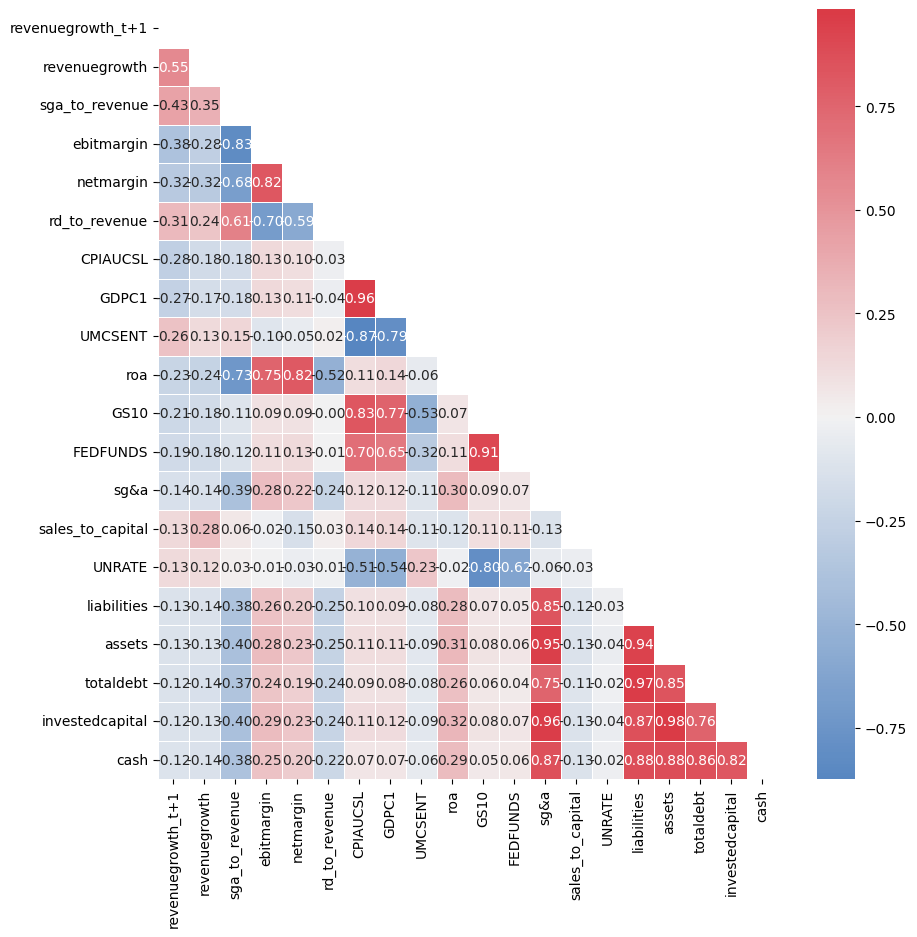

In [71]:
# Zoom into Top 19–20 Variables most correlated with the target variable revenuegrowth_t+1

plt.figure(figsize=(10, 10))

sns.heatmap(companies_corr_matrix.iloc[:20, :20],
            annot = True,
            cmap = my_cmap, 
            # we have to limit also mask!
            mask = mask[:20, :20],
            fmt = ".2f", 
            linewidths = 0.5,
            center = 0)

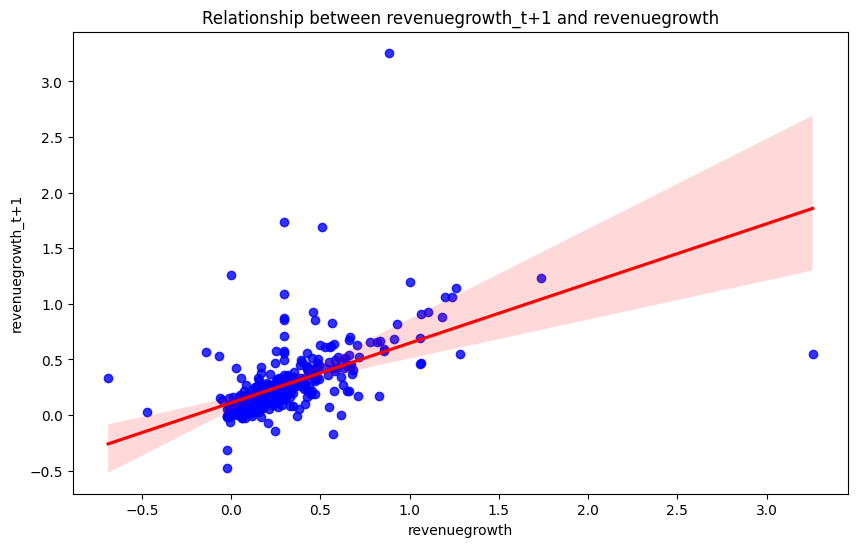

In [72]:
# correlation of the target variable
# with four the most influencial indepednent variables

plt.figure(figsize=(10, 6))
sns.regplot(x = 'revenuegrowth', 
            y = 'revenuegrowth_t+1', 
            data = companies_train,
            scatter_kws = {'color': 'blue'}, # kolor punktów
            line_kws = {'color': 'red'})     # kolor linii regresji
plt.title('Relationship between revenuegrowth_t+1 and revenuegrowth')
plt.xlabel('revenuegrowth')
plt.ylabel('revenuegrowth_t+1')
plt.show()

Interpretation:
- Clear positive linear trend.;
- The red regression line shows that past revenue growth is a strong predictor of next-year revenue growth.
- Confidence interval (shaded area) is tight in the central range, which shows good model fit for the bulk of the data.
- Some outliers on the high-growth side, but they do not dominate.

Financial Intuition:

Firms with high momentum (growth in t) tend to continue growing — common in SaaS/IT companies. This variable is strongly justified to be included in your model.

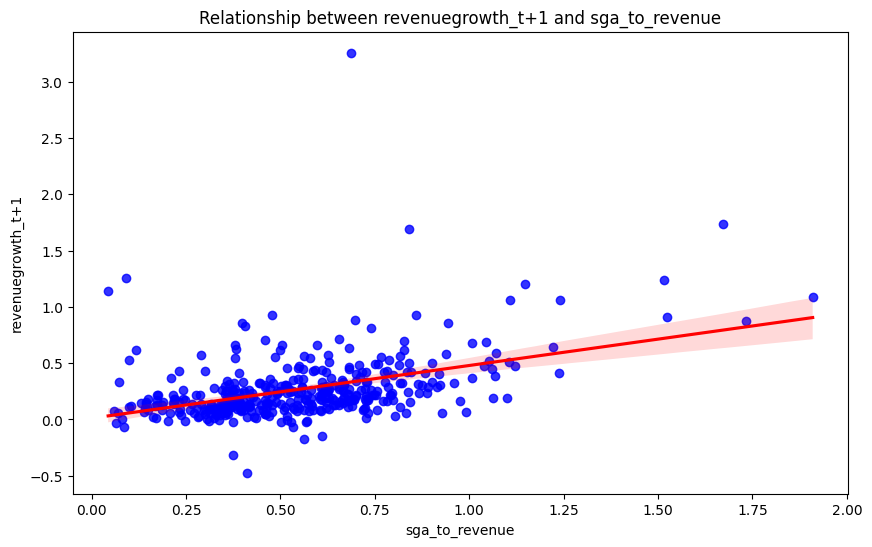

In [73]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'sga_to_revenue', 
            y = 'revenuegrowth_t+1', 
            data = companies_train,
            scatter_kws = {'color': 'blue'}, # kolor punktów
            line_kws = {'color': 'red'})     # kolor linii regresji
plt.title('Relationship between revenuegrowth_t+1 and sga_to_revenue')
plt.xlabel('sga_to_revenue')
plt.ylabel('revenuegrowth_t+1')
plt.show()

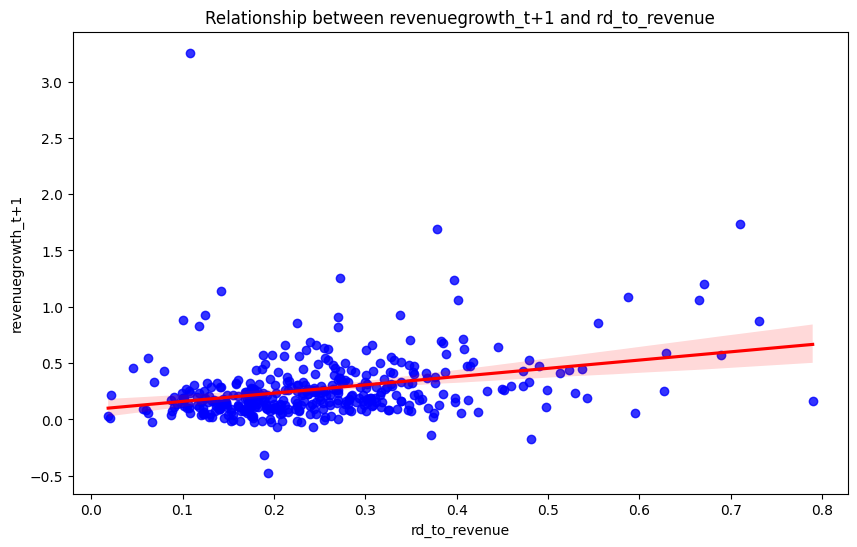

In [74]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'rd_to_revenue', 
            y = 'revenuegrowth_t+1', 
            data = companies_train,
            scatter_kws = {'color': 'blue'}, # kolor punktów
            line_kws = {'color': 'red'})     # kolor linii regresji
plt.title('Relationship between revenuegrowth_t+1 and rd_to_revenue')
plt.xlabel('rd_to_revenue')
plt.ylabel('revenuegrowth_t+1')
plt.show()

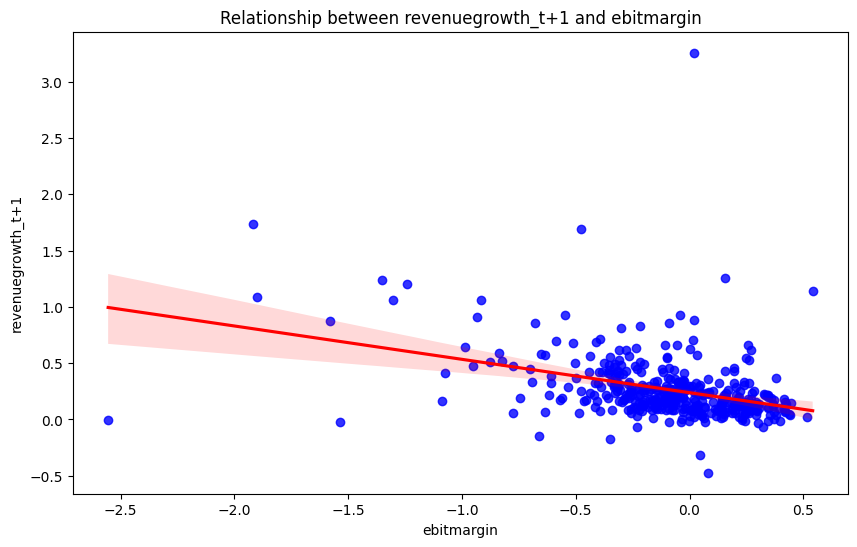

In [75]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'ebitmargin', 
            y = 'revenuegrowth_t+1', 
            data = companies_train,
            scatter_kws = {'color': 'blue'}, # kolor punktów
            line_kws = {'color': 'red'})     # kolor linii regresji
plt.title('Relationship between revenuegrowth_t+1 and ebitmargin')
plt.xlabel('ebitmargin')
plt.ylabel('revenuegrowth_t+1')
plt.show()

Interpretation:
- Negative linear trend: higher EBIT margins correlate with lower future revenue growth.;
- Most of the cloud is clustered around low EBIT margin and low growth.
- Some negative outliers, but regression line is stable.

Financial Intuition:
- In tech/SaaS, fast-growing firms often sacrifice margins for growth (investing in expansion, burning cash);
- Profitable companies might be more mature, with slower growth rates.;
- So this negative correlation makes sense — growth firms are often not yet profitable.

The visible outliers in the plots — especially those with high revenue growth but low or negative EBIT margins — likely represent high-growth companies that are burning cash.

This is a common phenomenon in sectors like SaaS, IT, and AI, where companies prioritize scaling over short-term profitability. These firms often reinvest heavily in marketing, R&D, or infrastructure to acquire users and expand market share, even at the cost of negative earnings or margins.

Companies in the AI sector — particularly early-stage or growth-phase firms — are likely to cluster in the upper-left quadrant of the EBIT margin vs. revenue growth plot.

This quadrant reflects firms with:
- High revenue growth (positive y-axis)
- Negative or low EBIT margins (left side of x-axis)

These companies often prioritize scaling and innovation, which leads to high operational costs (e.g., R&D, cloud infrastructure, talent acquisition), and hence lower current profitability. At the same time, they may achieve rapid top-line expansion due to high market demand or disruptive business models.

Final variable selection

Arguments based on:
- Correlation with the target (revenuegrowth_t+1);
- Redundancy / multicollinearity;
- Predictive intuition (financial & macro);
- Relevance at prediction time (no leakage)

When not to keep a variable:
- Any future info (e.g. revenuegrowth_t+1 itself): Data leakage;
- Highly correlated proxies (ebitmargin, netmargin, roa all together): Multicollinearity — hurts interpretability and stability;
- Variables computed from targets: Makes the model cheat without generalizing

##### Features to KEEP
1. revenuegrowth:
   - Correlation: +0.55 (very strong);
   - Justification: Prior year’s revenue growth is a powerful momentum predictor, often used in earnings forecasting and DCF modeling. Known at time t, highly informative.
2. sga_to_revenue:
   - Correlation: +0.45;
   - Justification: This ratio indicates how much is being spent to support growth. Startups and fast-growing firms often have high SG&A. Though counterintuitive, a high ratio may imply future scaling (in tech/early-stage sectors).
3. rd_to_revenue
   - Correlation: +0.29
   - Justification: A classic signal of innovation and future growth. High R&D intensity often correlates with new product pipelines and expansion in tech-driven industries.
4. ebitmargin:
   - Correlation: −0.37;
   - Justification: More profitable firms may grow more slowly (maturity effect). Still a valuable inverse signal, helps distinguish high-margin, low-growth firms from reinvestment-phase companies.
5. CPIAUCSL
   - Correlation: −0.31;
   - Justification: Measures inflation. High inflation erodes purchasing power and compresses growth. A macro headwind — weak correlation, but still predictive and interpretable.
6. GDPC1
   - Correlation: −0.30
   - Justification: Real GDP growth. Useful for benchmarking firm performance relative to the macro economy. Lower GDP might imply firms outperforming macro in weak cycles.
7. UMCSENT
   - Correlation: +0.28;
   - Justification: Consumer sentiment. A leading macroeconomic indicator — rising optimism can drive spending, capex, and B2B investment.

**Features to DROP**

Redundant / Highly Correlated

1. netmargin, ebit, roa, nopat:
- All highly correlated with netmargin (≥ 0.8). Keeping ebitmargin suffices for profitability signal.
2. assets, liabilities, investedcapital, sg&a:
- Highly correlated with each other and with totaldebt. They all scale with company size and bring little marginal value.

Weak Signal (|r| ≤ 0.20)

1. UNRATE;
2. FEDFUNDS, GS10.

In [76]:
# Select Top Numeric Predictors by Correlation
# Skip the first variable (index 0), which is the target itself (correlation = 1 with itself).
# Final outcome is a list of 15 variables that are best correlated with your target, either positively or negatively.
companies_selected_numeric_vars = companies_corr_matrix.index[1:16].tolist()

print(companies_selected_numeric_vars)

['revenuegrowth', 'sga_to_revenue', 'ebitmargin', 'netmargin', 'rd_to_revenue', 'CPIAUCSL', 'GDPC1', 'UMCSENT', 'roa', 'GS10', 'FEDFUNDS', 'sg&a', 'sales_to_capital', 'UNRATE', 'liabilities']


In [77]:
# Drop Multicollinear or Redundant Variables
# I am manually removing variables that:
# May be multicollinear (e.g. netmargin, roa);
# Are macroeconomic indicators (GS10, FEDFUNDS, UNRATE) which may not vary much within your firm-level dataset;
# Might be too general or redundant (e.g., sg&a, UMCSENT);
# To did this I used domain knowledge and statistical prudence;
# main goal: reducing dimensionality and avoiding noise or overfitting.

cols_to_remove = ['netmargin', 'roa', 'GS10', 'UNRATE', 'sg&a', 'FEDFUNDS', 'sales_to_capital', 'UMCSENT']
companies_selected_numeric_vars = [col for col in companies_selected_numeric_vars if col not in cols_to_remove]

# Print the filtered list
print(companies_selected_numeric_vars)

['revenuegrowth', 'sga_to_revenue', 'ebitmargin', 'rd_to_revenue', 'CPIAUCSL', 'GDPC1', 'liabilities']


In [78]:
# Extract Categorical Variables

companies_categorical_variable = companies_train.select_dtypes("category").columns

print(companies_categorical_variable)

Index(['label'], dtype='object')


In [79]:
# Checking the distribution of companies by sector label in the training data
companies_train["label"].value_counts()

label
Cloud & Data        97
Enterprise SaaS     73
Vertical SaaS       73
Collab & CX SaaS    47
AI‑DevOps           42
Consumer SaaS       25
Mega‑Cap Tech       21
Mature Pivots       17
Name: count, dtype: int64

In [80]:
# Run ANOVA Test for the Categorical Variable label

# Since the dependent variable is quantitative (revenuegrowth_t+1)
# and the predictor is qualitative (categorical),
# we can use ANOVA (Analysis of Variance) to test for group differences.

# Estimate an ANOVA model — this is equivalent to a linear regression
# with one categorical predictor.

# Rename to avoid syntax issues in formulasy
companies_train = companies_train.rename(columns={"revenuegrowth_t+1": "revenuegrowth_t_plus_1"})

# Fit OLS regression treating 'label' as a categorical variable
# C(label) tells statsmodels to automatically dummy-code the variable.
model = smf.ols('revenuegrowth_t_plus_1 ~ C(label)', data=companies_train).fit()
# Run ANOVA on the model
# The model is a one-way ANOVA: it checks whether the mean of revenuegrowth_t+1 differs across company groups.
anova_table = anova_lm(model)
print(anova_table)

             df     sum_sq   mean_sq         F    PR(>F)
C(label)    7.0   1.288392  0.184056  2.198906  0.033626
Residual  387.0  32.393245  0.083703       NaN       NaN


In [81]:
# The F-statistic from the ANOVA table quantifies the ratio of between-group to within-group variance
# A higher F-value suggests stronger group separation.
# The associated p-value (also in the anova_table) indicates statistical significance.

anova_table['F'].iloc[0]  # kolumna 'F', pierwszy wiersz (dla label)

2.1989058249923126

1. What hypothesis is being tested?

- Null (H₀): all nine category means of the dependent variable are equal (no systematic effect);
- Alternative (H₁): at least one category mean differs.

The F-statistic 𝐹 = 2.198906 is the ratio of the “between-group” variance (due to the categories) to the “within-group” variance (the residual).

2. Interpreting the p-value:
- PR(>F) = 0.033626 is the probability of getting an F-statistic as extreme as 2.198906 (or more extreme) if the null hypothesis were true;
- At the conventional 5 % significance level you reject H₀ (0.033626 < 0.05).
- At the stricter 1 % level we would not reject there.

So statistically, the overall F-test says the factor is informative and label adds explanatory power—there is evidence the dependent variable differs across at least one pair of categories.

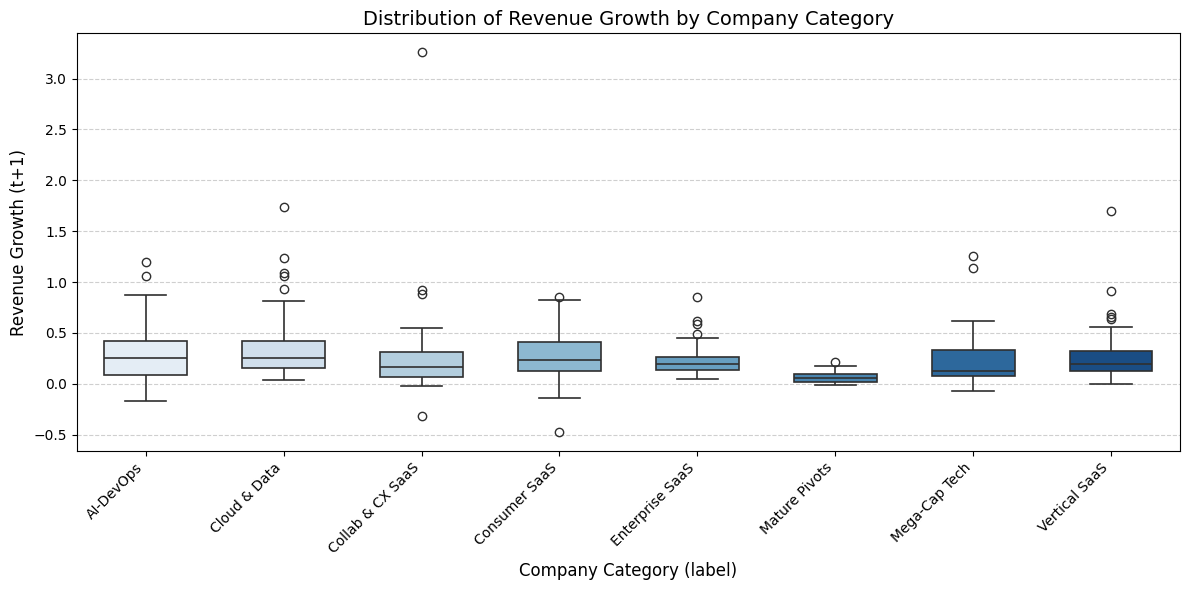

In [82]:
# Check the relation between categorical variable and predicted variable
# A boxplot that shows the distribution of next-year revenue growth for each company category.
# Each box: represents a category (e.g. AI, SaaS, IT infra...);
# Line inside box: median
# Box width: IQR (25–75th percentile)
# Whiskers/outliers: show spread and extremes

plt.figure(figsize=(12, 6))  # Increase width for readability

sns.boxplot(
    x='label',
    y='revenuegrowth_t_plus_1',
    hue = 'label',
    data=companies_train,
    palette='Blues',  # Better visual gradient
    width=0.6,        # Make boxes slightly narrower
    linewidth=1.2     # Sharper outlines
)

# label formatting
plt.xlabel("Company Category (label)", fontsize=12)
plt.ylabel("Revenue Growth (t+1)", fontsize=12)
plt.title("Distribution of Revenue Growth by Company Category", fontsize=14)

# Rotate x-tick labels for clarity
plt.xticks(rotation=45, ha='right', fontsize=10)

# Clean up layout and show grid
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Financial and Modeling Implications:
- The category (label) variable is meaningful: Different groups show distinct growth profiles;
- The differences observed visually are statistically supported by the ANOVA F-test, suggesting the category explains variance in future revenue growth;

The conclusion:
- I should include label in your regression model as one-hot encoded features;
- use it to stratify the analysis or model segments (I did it already in the previous cleaning step).
  

In [83]:
#  Manually selecting 'label' as your best categorical variable ( becouse I have only one)

companies_selected_categorical_vars = ["label"] # Gives us the column name as a list)

print(companies_selected_categorical_vars)

['label']


In [84]:
# Combine Selected Variables
# 7 numerycznych zmiennych najbardziej skorelowanych ze zmienną celu
# +1 categorical predictor (label)
# Concatenates list of column names
companies_selected_vars = companies_selected_numeric_vars + companies_selected_categorical_vars

print(companies_selected_vars)

['revenuegrowth', 'sga_to_revenue', 'ebitmargin', 'rd_to_revenue', 'CPIAUCSL', 'GDPC1', 'liabilities', 'label']


In [85]:
# Save the Selected Features List
with open("outputs/companies_selected_vars.pkl", "wb") as f:
    pickle.dump(companies_selected_vars, f)